In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle as pic
from sklearn.model_selection import train_test_split

In [4]:
from joblib import Parallel, delayed
from templates import guessing_entropy
BINS = 10
REPEAT = 100
def compute_mean_ranks(per_trace: np.ndarray, key: np.ndarray):
    mean_ranks = np.zeros((per_trace.shape[1], BINS), dtype=np.longfloat)
    for bin_ in range(BINS):
        print(bin_)
        n_traces = bin_ * per_trace.shape[0] // BINS

        #def guess():
        #    subset = np.random.choice(per_trace.shape[0], size=n_traces, replace=False)
        #    return guessing_entropy(np.sum(per_trace[subset], axis=0), key)
            
        #ranks = Parallel(n_jobs=-1)(delayed(guess)() for _ in range(REPEAT))

        rank = np.zeros(per_trace.shape[1], dtype=int)
        for _ in range(REPEAT):
            print(_, end="\r")
            subset = np.random.choice(per_trace.shape[0], size=n_traces, replace=False)
            rank += guessing_entropy(np.sum(per_trace[subset], axis=0), key)
        mean_ranks[:, bin_] = rank / REPEAT
    return mean_ranks

In [5]:
with open("full_data.pic", "rb") as r:
    seeds_total, traces_total, key, output_total, keyshares_total, perms_total = pic.load(r)

## 45'000 extraction traces (350'000 profiling)

In [ ]:
TRAIN_SIZE = 350_000

In [ ]:
with open("full_data.pic", "rb") as r:
    seeds_total, traces_total, key, output_total, keyshares_total, perms_total = pic.load(r)
with open("per_trace_350000.pic", "rb") as r:
    per_trace = pic.load(r)

In [ ]:
_, seeds_extraction = train_test_split(seeds_total, train_size=TRAIN_SIZE, random_state=0)
classifications_per_key_nibble = np.sum(per_trace, axis=0)
mean_ranks = compute_mean_ranks(per_trace, key)

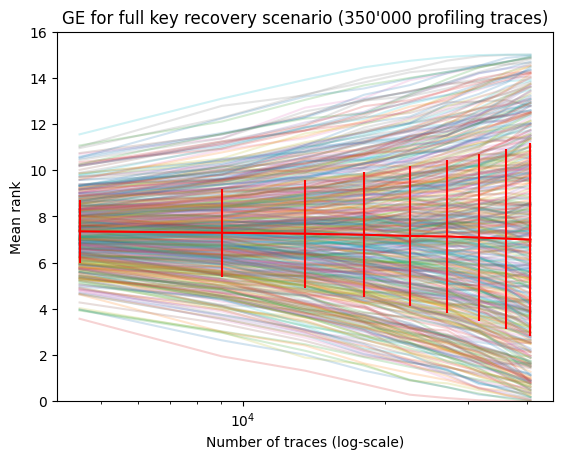

In [116]:
for n, nibble_ranks in enumerate(mean_ranks):
    plt.plot(range(0, per_trace.shape[0], per_trace.shape[0] // BINS)[1:-1], nibble_ranks[1:], label=f"Key nibble {n}", alpha=0.2)
plt.errorbar(range(0, per_trace.shape[0], per_trace.shape[0] // BINS)[1:-1], np.mean(mean_ranks, axis=0)[1:], np.std(mean_ranks, axis=0)[1:], color="red")
plt.xscale("log")
plt.title("GE for full key recovery scenario (350'000 profiling traces)")
plt.xlabel("Number of traces (log-scale)")
plt.ylabel("Mean rank")
plt.ylim([0, 16])
#plt.legend()
plt.show()

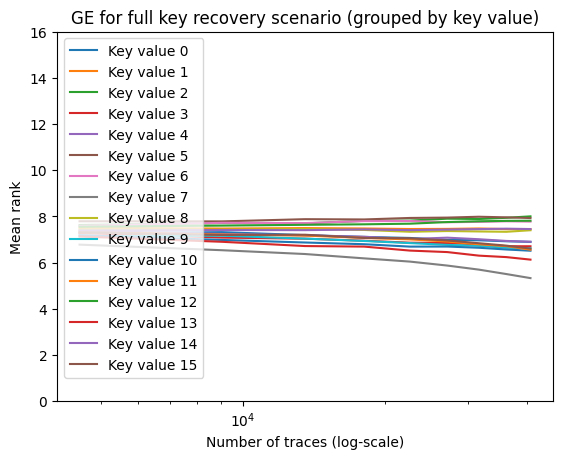

In [34]:
from utils import KEY_ALPHABET
for k in KEY_ALPHABET:
    mean_ranks[key == k]
    plt.plot(range(0, per_trace.shape[0], per_trace.shape[0] // BINS)[1:-1], np.mean(mean_ranks[key == k], axis=0)[1:], label=f"Key value {k}")
plt.xscale("log")
plt.title("GE for full key recovery scenario (grouped by key value)")
plt.xlabel("Number of traces (log-scale)")
plt.ylabel("Mean rank")
plt.legend()
plt.ylim([0, 16])
plt.show()

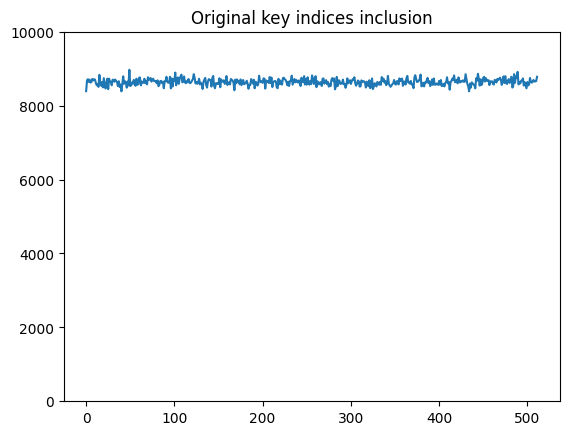

In [88]:
from utils import chacha_random_b4
plt.plot(*np.unique(np.array([chacha_random_b4(seed)[0][:98] for seed in seeds_extraction]), return_counts=True))
#plt.xlim([305, 315])
plt.ylim([0, 10_000])
plt.title("Original key indices inclusion")
plt.show()

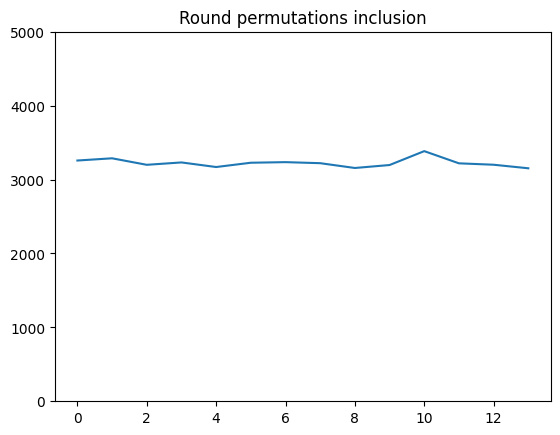

In [97]:
plt.plot(*np.unique(train_test_split(perms_total, train_size=TRAIN_SIZE, random_state=0)[1][:, 1], return_counts=True))
#plt.xlim([305, 315])
plt.ylim([0, 5_000])
plt.title("Round permutations inclusion")
plt.show()

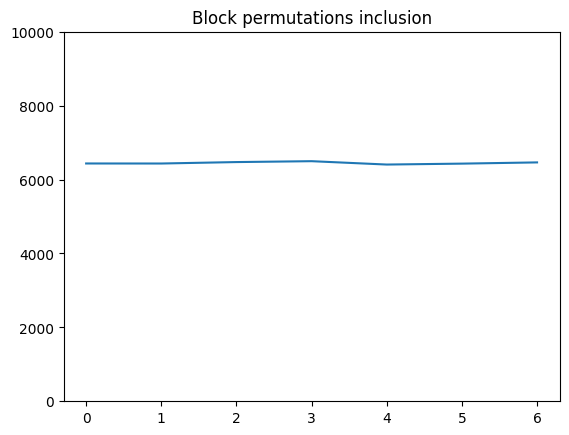

In [98]:
plt.plot(*np.unique(train_test_split(perms_total, train_size=TRAIN_SIZE, random_state=0)[1][:, 2], return_counts=True))
#plt.xlim([305, 315])
plt.ylim([0, 10_000])
plt.title("Block permutations inclusion")
plt.show()

In [104]:
from templates import get_masks_labels
masks_labels = get_masks_labels(seeds_extraction, key, train_test_split(keyshares_total, train_size=TRAIN_SIZE, random_state=0)[1], train_test_split(perms_total, train_size=TRAIN_SIZE, random_state=0)[1][:, 1], train_test_split(perms_total, train_size=TRAIN_SIZE, random_state=0)[1][:, 2:3:1])

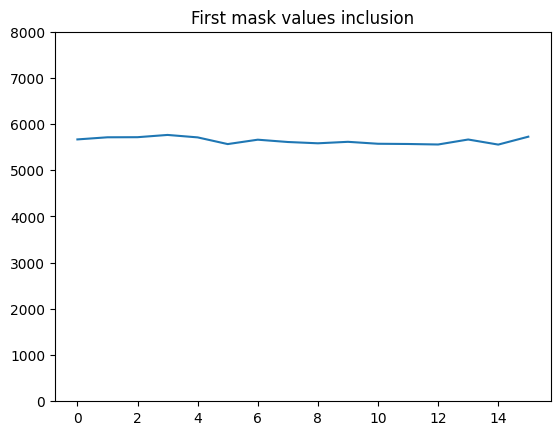

In [111]:
plt.plot(*np.unique(masks_labels[:, 0], return_counts=True))
#plt.xlim([305, 315])
plt.ylim([0, 8000])
plt.title("First mask values inclusion")
plt.show()

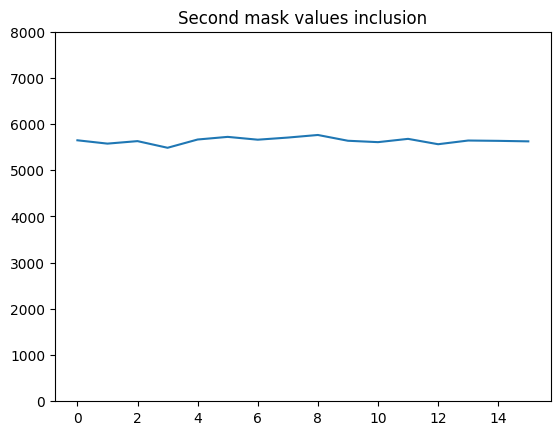

In [109]:
plt.plot(*np.unique(masks_labels[:, 1], return_counts=True))
#plt.xlim([305, 315])
plt.ylim([0, 8000])
plt.title("Second mask values inclusion")
plt.show()

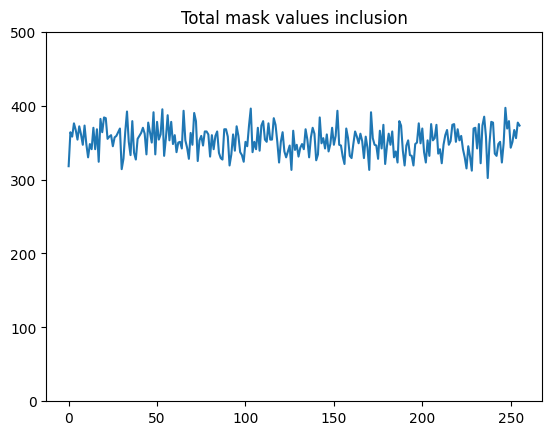

In [112]:
plt.plot(*np.unique(16 * masks_labels[:, 0] + masks_labels[:, 1], return_counts=True))
#plt.xlim([305, 315])
plt.ylim([0, 500])
plt.title("Total mask values inclusion")
plt.show()

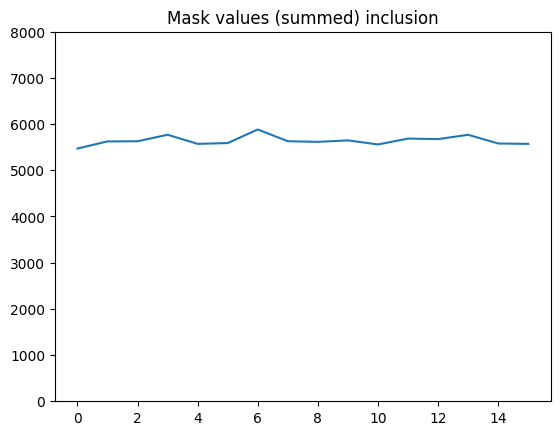

In [114]:
plt.plot(*np.unique((masks_labels[:, 0] + masks_labels[:, 1]) % 16, return_counts=True))
#plt.xlim([305, 315])
plt.ylim([0, 8_000])
plt.title("Mask values (summed) inclusion")
plt.show()

## 100'000 extraction traces (295'000 profiling)

In [6]:
TEST_SIZE = 100_000

In [7]:
with open("y_extraction_epoch_35.pic", "rb") as r:
    y_predicted = pic.load(r)

In [8]:
from templates import classifications_per_trace, reconstruct_key
_, seeds_extraction = train_test_split(seeds_total, test_size=TEST_SIZE, random_state=0)
round_perm_probas = y_predicted[0]
copy_perm_probas = y_predicted[1][:, np.newaxis, :]
masks_probas = np.stack(y_predicted[2:], axis=1)[:, np.newaxis, ...]

per_trace = classifications_per_trace(seeds_extraction, np.zeros((seeds_extraction.shape[0], 98)), np.zeros((seeds_extraction.shape[0], 98, 256)), round_perm_probas, copy_perm_probas, masks_probas, masks_rws_keep_only=np.empty((98, 0)), parallel=True)
recovered_key = reconstruct_key(per_trace)

In [9]:
classifications_per_key_nibble = np.sum(per_trace, axis=0)
mean_ranks = compute_mean_ranks(per_trace, key)
with open("mean_ranks_300000.pic", "wb") as w:
    pic.dump(mean_ranks, w)

0
19
29
39
49
59
69
79
89
99


In [28]:
mean_ranks = np.concatenate((mean_ranks, guessing_entropy(np.sum(per_trace, axis=0), key)[:, np.newaxis]), axis=1)

In [32]:
mean_ranks = mean_ranks[:, :-1]

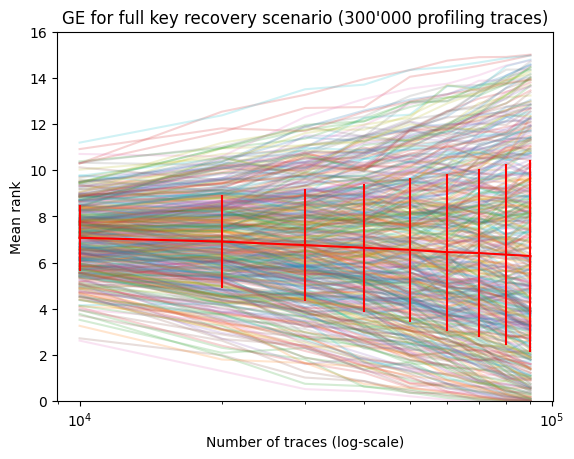

In [9]:
for n, nibble_ranks in enumerate(mean_ranks):
    plt.plot(range(0, per_trace.shape[0], per_trace.shape[0] // BINS)[1:], nibble_ranks[1:], label=f"Key nibble {n}", alpha=0.2)
plt.errorbar(range(0, per_trace.shape[0], per_trace.shape[0] // BINS)[1:], np.mean(mean_ranks, axis=0)[1:], np.std(mean_ranks, axis=0)[1:], color="red")
plt.xscale("log")
plt.title("GE for full key recovery scenario (300'000 profiling traces)")
plt.xlabel("Number of traces (log-scale)")
plt.ylabel("Mean rank")
plt.ylim([0, 16])
#plt.legend()
plt.show()

In [36]:
np.mean(mean_ranks, axis=0)[1:]

array([7.07128906, 6.90603516, 6.75365234, 6.63802734, 6.55037109,
       6.44861328, 6.41083984, 6.34001953, 6.28273438], dtype=float64)